# Support Vector Machine
Aims to address the situation where the boundry between two classes is not linear.

In [26]:
from sklearn.preprocessing import PolynomialFeatures

def non_linear_examples():
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 5))
    axes = axes.flatten()
    plt.sca(axes[0])
    nl1, y1 = datasets.make_classification(n_samples=300, n_features=2, 
                                          n_redundant=0, n_informative= 2, 
                                          n_classes=3, n_clusters_per_class=1, 
                                          random_state=14, class_sep=30, 
                                          hypercube=False)
    y1 = np.where(y1==1,0,y1)
    y1 = np.where(y1==2,1,y1)
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[1])
    nl2, y2 = make_moons(n_samples=300, noise=0.15, random_state=42)
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    svm_clf1 = LinearSVC(random_state=42).fit(nl1, y1)
    svm_clf2 = LinearSVC(random_state=42).fit(nl2, y2)

    # Convert to unscaled parameters
    b1 = svm_clf1.intercept_[0]
    b2 = svm_clf2.intercept_[0]
    w1 = svm_clf1.coef_[0]
    w2 = svm_clf2.coef_[0]

    # Find support vectors (LinearSVC does not do this automatically)
    t1 = y1 * 2 - 1
    t2 = y2 * 2 - 1
    support_vectors_idx1 = (t1 * (nl1.dot(w1) + b1) < 1).ravel()
    support_vectors_idx2 = (t2 * (nl2.dot(w2) + b2) < 1).ravel()
    svm_clf1.support_vectors_ = nl1[support_vectors_idx1]
    svm_clf2.support_vectors_ = nl2[support_vectors_idx2]

    plt.sca(axes[2])
    plot_svc_decision_boundary(svm_clf1, -5, 4, highlight=False)
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    plot_svc_decision_boundary(svm_clf2, -1.5, 2.5, highlight=False)
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)

    plt.show()

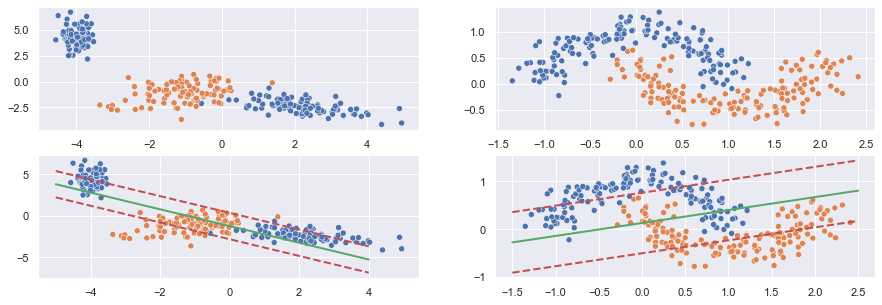

In [27]:
import warnings
# TEMP
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    non_linear_examples()

- A hyperplane does not need to be linear as the input feature space can be projected to higher dimensions using a kernel (e.g. radial basis kernel<sup>2,3</sup>), allowing a hyperplane to be fitted to split the data into classes. The data can then be mapped back into the original feature space to create a nonlinear separation boundary.

---
2. Cover, T. M. (1965). Geometrical and statistical properties of systems of linear inequalities with applications in pattern recognition. IEEE transactions on electronic computers, (3), 326-334.
3. Varsavsky, A., Mareels, I., & Cook, M. (2016). Epileptic seizures and the EEG: measurement, models, detection and prediction. CRC Press.

We could consider enlarging the feature space using quadratic, cubic or higher-order polynomial functions, however the larger the number of features, the higher computational burden. Instead it is common to enlarge the feature space using an extension of a SVC termed a Support Vector Machine, which uses _kernels_.

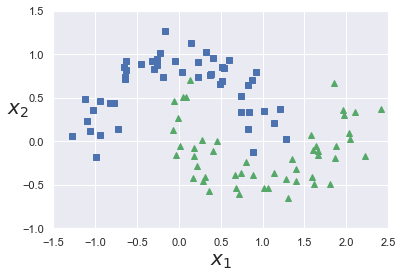

In [28]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [29]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_feat = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='poly', degree=3, C=10, random_state=42))
    ])

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Polynomial Feature Engineering")
    %timeit polynomial_feat.fit(X, y)
    print("Polynomial Kernel")
    %timeit polynomial_svm.fit(X, y)

Polynomial Feature Engineering
1.35 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Polynomial Kernel
1.11 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


...although in this case (with these specific hyperparameters) the feature engineering performs better. SVM can be sensitive to hyperparameter settings so we need to normally cross-validate these!

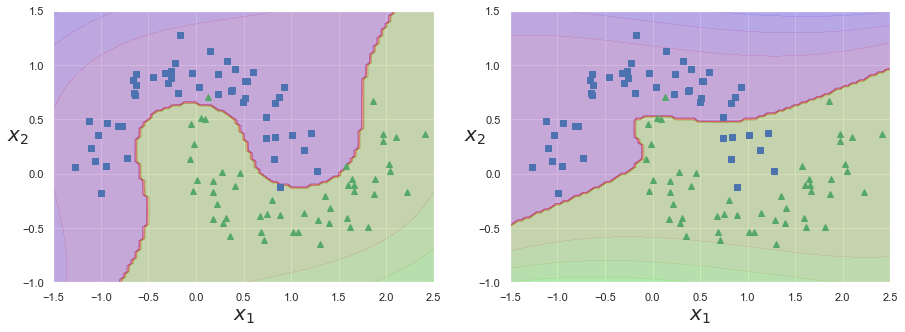

In [31]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plot_predictions(polynomial_feat, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.sca(axes[1])
plot_predictions(polynomial_svm, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

The kernel apporach is an efficient computational approach to enlarge our feature space to accommodate a non-linear boundary.

Skipping over some technical details (see __REF__), it turns out we can use the inner products of two observations rather than using the observations themselves:

$<x_i,x_{i^{\prime}}> = \sum^P_{j=1}x_{ij}x_{i^{\prime}j}$.

Using this we can represent the linear support vector classifier as: 

$f(x) = \beta_0 + \sum^n_{i=1}\alpha_i<x,x_i>$.

In the above case, for estimating the parameters $\alpha_1...,\alpha_n$ and $\beta_0$, we need the $n(n-1)/2$ inner products $<x,x_i>$ between all pairs of training observations. Similarly, if wanted to compute $f(x)$ we would need to the inner product between $x$ and each training point $x_i$.

However, $\alpha$ is nonzero only for support vectors, so if we have a collection of indicies of these support points we can do the following instead:

$f(x) = \beta_0 + \sum_{i\in S}\alpha_i<x,x_i>$.

Also instead of actually calculating the inner product, we could instead use a _generalisation_, $K(x,x_{i^{\prime}})$, where $K$ is a _kernel_. We can now define the classifier as:

$f(x) = \beta_0 + \sum_{i\in S}\alpha_iK(x,x_i)$.

A kernel is a function that quantifies the similarity of two observations. For example, for a _linear kernel_ we could use:

$K(x_i, x_{i'}) = \sum^P_{j=1}x_{ij}x_{i'j}$,

where we quantifiy the similarity of pairs of observations using Pearson (standard) correlation.

However, we could use other forms of kernel to fit the support vector classifier in a higher-dimensional space, such as a _polynomial kernel_:

$K(x_i, x_{i'}) = (1+\sum^P_{j=1}x_{ij}x_{i'j})^d$,

where d is a positive integer.

__[MORE INFO ON polynomial kernels]__

In [32]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def poly_info():
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    plt.figure(figsize=(10, 3))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
    plt.gca().get_yaxis().set_ticks([])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.axis([-4.5, 4.5, -0.2, 0.2])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
    plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
    plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
    plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
    plt.axis([-4.5, 4.5, -1, 17])

    plt.subplots_adjust(right=1)

    plt.show()

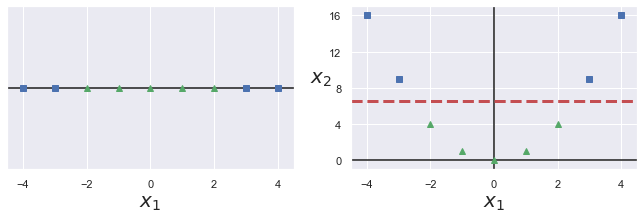

In [33]:
poly_info()

Another popular choice is the _radial kernel_:

$K(x_i, x_{i'}) = exp(-\gamma\sum^P_{j=1}(x_{ij}-x_{i'j})^2)$,

where $\gamma$ is a positive integer.

In [34]:
def non_linear_examples():
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 5))
    axes = axes.flatten()
    plt.sca(axes[0])
    nl1, y1 = datasets.make_classification(n_samples=300, n_features=2, 
                                          n_redundant=0, n_informative= 2, 
                                          n_classes=3, n_clusters_per_class=1, 
                                          random_state=14, class_sep=30, 
                                          hypercube=False)
    y1 = np.where(y1==1,0,y1)
    y1 = np.where(y1==2,1,y1)
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[1])
    nl2, y2 = make_moons(n_samples=300, noise=0.15, random_state=42)
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    svm_clf1 = SVC(random_state=42).fit(nl1, y1)
    svm_clf2 = SVC(random_state=42).fit(nl2, y2)

    plt.sca(axes[2])
    plot_predictions(svm_clf1, [-5, 5, -5, 7.5])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    plot_predictions(svm_clf2, [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    plt.suptitle('Radial Basis Kernel')

    plt.show()

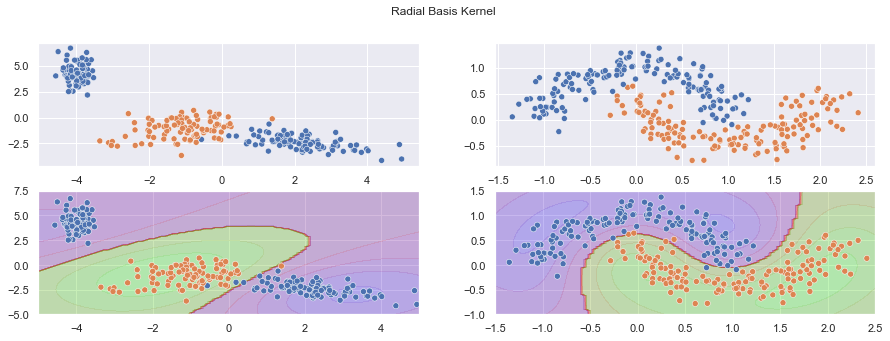

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    non_linear_examples()

When using a SVM model trained using a RBF kernel classifies a test observation $x^* = (x^*_1...x^*_p)T$, only training observaations close to $x^*$ (in terms of Euclidean distance) will play a role in its class label. This is because $(x^*_j-x_{ij})^2$ will be large, so $exp(-\gamma\sum^P_{j=1}(x^*_j-x_{ij})^2)$ will be small.

__[MORE INFO ON RBF kernels]__

In [38]:
# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def gaussian_rbf(x, landmark, gamma):
        return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

def rbk_info():

    gamma = 0.3
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
    x2s = gaussian_rbf(x1s, -2, gamma)
    x3s = gaussian_rbf(x1s, 1, gamma)

    XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
    yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    plt.figure(figsize=(10.5, 4))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
    plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
    plt.plot(x1s, x2s, "g--")
    plt.plot(x1s, x3s, "b:")
    plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"Similarity", fontsize=14)
    plt.annotate(r'$\mathbf{x}$',
                 xy=(X1D[3, 0], 0),
                 xytext=(-0.5, 0.20),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
    plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
    plt.axis([-4.5, 4.5, -0.1, 1.1])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
    plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
    plt.xlabel(r"$x_2$", fontsize=20)
    plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
    plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
                 xy=(XK[3, 0], XK[3, 1]),
                 xytext=(0.65, 0.50),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
    plt.axis([-0.1, 1.1, -0.1, 1.1])

    plt.subplots_adjust(right=1)

    plt.show()

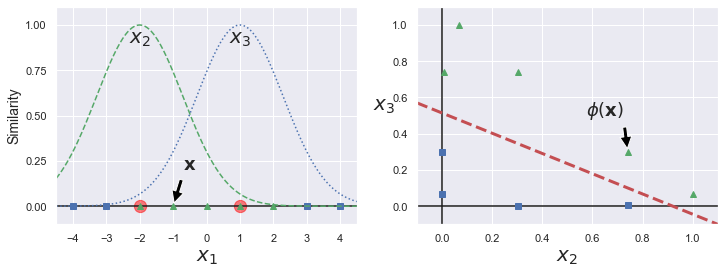

In [39]:
rbk_info()

__[MORE INFO ON HOW C AND GAMMA INTERACT]__

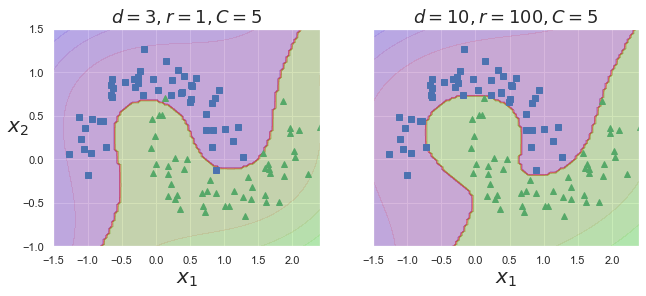

In [40]:
from sklearn.svm import SVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


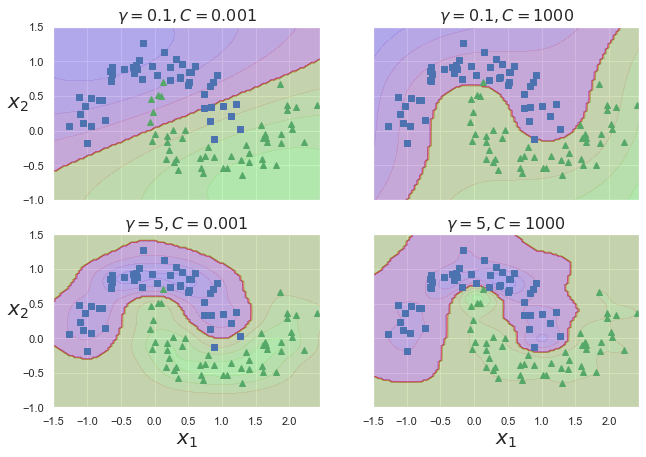

In [42]:
gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]


x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))
    
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

## Exercises

# References
1. Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of eugenics, 7(2), 179-188.
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
5. Raschka, 2016

web1.  https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
web2. https://scikit-learn.org/stable/datasets/toy_dataset.html